In [1]:
%cd /kaggle/working
%rm -rf /kaggle/working/*

/kaggle/working


In [2]:
import pandas as pd
import polars as pl
import yaml
import sys
import os
from glob import glob
import gc
from pathlib import Path
import pickle
from tqdm import tqdm
import numpy as np
from multiprocessing import Pool

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torchmetrics import MetricCollection, MeanSquaredError

sys.path.append('/kaggle/src')
from utils.metric import compute_comptetition_metric
from utils.set_seed import seed_base_torch
from utils.feature_contena import Features
from utils.lightning_utils import MyLightningDataModule, MyLightningModule
from utils.postprocess import dynamic_range_nms
from torch_models.dataset import ZzzPatchDataset
from torch_models.models import ZzzConv1dGRUModel

MODEL_NAME = "stacking"

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base_torch(CFG["env"]["seed"])

BLOCK_SIZE = CFG[MODEL_NAME]["execution"]["block_size"]

2023-11-07 17:09:09.347491: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib
2023-11-07 17:09:09.353849: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib
2023-11-07 17:09:09.353864: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlo

exp_125


In [3]:
oofs = []
for model in CFG[MODEL_NAME]["execution"]["models"]:
    exp_id = CFG[model]["execution"]["best_exp_id"]
    if os.path.exists(f'/kaggle/output/{exp_id}/oof.csv'):
        oof = pl.read_csv(f'/kaggle/output/{exp_id}/oof.csv')
    else:
        oof = pl.read_parquet(f'/kaggle/output/{exp_id}/oof.parquet')
    oofs.append(oof)

oofs.append(pl.read_parquet(f'/kaggle/output/tubo_based/exp019_oof.parquet'))

In [10]:
features = Features()
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
dfs = []
for file in tqdm(files):
    df = pl.read_parquet(file).sort("step")
    sid = df.get_column("series_id")[0]

    for i, oof_df in enumerate(oofs):
        oof_sid_df = oof_df.with_columns(pl.col("step").cast(pl.UInt32)).filter(pl.col("series_id") == sid)
        if "onset_oof" in oof_sid_df.columns:
            onset_oof_df = oof_sid_df.select(["step", "onset_oof"]).rename({"onset_oof": f"onset_oof_{i}"})
            wakeup_oof_df = oof_sid_df.select(["step", "wakeup_oof"]).rename({"wakeup_oof": f"wakeup_oof_{i}"})
            df = df.join(onset_oof_df, on="step", how="left").join(wakeup_oof_df, on="step", how="left")
        else:
            wakeup_df = oof_sid_df.filter(pl.col("event") == "wakeup").select(["step", "score"]).rename({"score": f"wakeup_oof_{i}"})
            onset_df = oof_sid_df.filter(pl.col("event") == "onset").select(["step", "score"]).rename({"score": f"onset_oof_{i}"})
            df = df.join(onset_df, on="step", how="left").join(wakeup_df, on="step", how="left")
        features.add_num_features([f"onset_oof_{i}", f"wakeup_oof_{i}"])

    # 補間
    for i in range(len(oofs)): 
        df = df.with_columns([
            pl.col(f"onset_oof_{i}").interpolate().over("series_id").fill_null(0).alias(f"onset_oof_{i}"),
            pl.col(f"wakeup_oof_{i}").interpolate().over("series_id").fill_null(0).alias(f"wakeup_oof_{i}")
        ])

    df_pandas = df.to_pandas()
    df_pandas[features.all_features()] = df_pandas[features.all_features()].astype(np.float16)

    # target
    df_pandas["onset_target"] = df_pandas["onset_target"] / 10
    df_pandas["wakeup_target"] = df_pandas["wakeup_target"] / 10

    # cv
    fold_value = cv_split.loc[cv_split["series_id"] == sid, "fold"].values[0]
    df_pandas["fold"] = fold_value

    df_pandas.drop(columns=["timestamp", "anglez", "enmo", "event"], inplace=True)

    # BLOCK_SIZE ごとに分割
    for start in range(0, len(df_pandas), BLOCK_SIZE // 4):
        end = start + BLOCK_SIZE
        if end > len(df_pandas):
            # endをlen(df)未満の最大のpsの倍数にする
            end = len(df_pandas) - len(df_pandas) % CFG[MODEL_NAME]["execution"]["patch_size"]
            start = end - BLOCK_SIZE
        assert df_pandas.iloc[start]["step"] % CFG[MODEL_NAME]["execution"]["patch_size"] == 0
        dfs.append(df_pandas.iloc[start:end])
    gc.collect()

  0%|          | 0/277 [00:00<?, ?it/s]

100%|██████████| 277/277 [06:19<00:00,  1.37s/it]


In [11]:
dataset_oof = ZzzPatchDataset(dfs, 'train', features, patch_size=CFG[MODEL_NAME]["execution"]["patch_size"])
feats, targets = dataset_oof[0]
feats.shape, targets.shape

((960, 48), (960, 2))

In [12]:
!rm -r logs

rm: cannot remove 'logs': No such file or directory


In [13]:
%%time

fold_oof_dfs = []
for fold in range(5):
    print(f"== fold {fold} ==")
    
    # 学習・評価データ
    train_dfs = [df for df in dfs if df["fold"].unique()[0] != fold]
    valid_dfs = [df for df in dfs if df["fold"].unique()[0] == fold]
    train_dataset = ZzzPatchDataset(train_dfs, 'train', features, patch_size=CFG[MODEL_NAME]["execution"]["patch_size"])
    valid_dataset = ZzzPatchDataset(valid_dfs, 'train', features, patch_size=CFG[MODEL_NAME]["execution"]["patch_size"])
    data_module = MyLightningDataModule(train_dataset, valid_dataset, batch_size=32)

    # モデル
    num_training_steps = len(train_dataset) // 32 * 10
    
    model = ZzzConv1dGRUModel(
        input_numerical_size=len(features.all_features()) * CFG[MODEL_NAME]["execution"]["patch_size"],
        **CFG[MODEL_NAME]["params"],
    )
    pl_model = MyLightningModule(
        model=model,
        lr=0.0005, 
        loss_fn=nn.BCEWithLogitsLoss(),
        num_training_steps=num_training_steps,
    )
    
    # コールバック
    cp_callback = ModelCheckpoint(
        "logs/", 
        filename=f"best_model_fold{fold}",
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        save_last=False,
    )
    es_callback = EarlyStopping(
        monitor="val_loss",
        mode="min",
        patience=4,
    )

    # 学習
    trainer = Trainer(
        callbacks=[cp_callback, es_callback],
        deterministic=True,
        val_check_interval=0.25,
        )
    trainer.fit(pl_model, datamodule=data_module)

    # 推論
    pl_model = MyLightningModule.load_from_checkpoint(
        f"logs/best_model_fold{fold}.ckpt", 
        model=model,
    ).to("cuda")
    pl_model.eval()
    preds = []
    with torch.no_grad():
        for X, y in data_module.val_dataloader():
            pred = torch.sigmoid(pl_model(X.to("cuda"))).detach().cpu().numpy() * 10
            preds.append(pred)

    oof_dfs = []
    for pred, df in zip(np.vstack(preds), valid_dfs):
        df = df.iloc[CFG[MODEL_NAME]["execution"]["patch_size"] // 2: len(df): CFG[MODEL_NAME]["execution"]["patch_size"]].reset_index(drop=True)
        df[["wakeup_oof", "onset_oof"]] = pred
        oof_dfs.append(df)

    oof_df = pd.concat(oof_dfs)
    oof_df = oof_df.groupby(["series_id", "step"]).mean().reset_index().sort_values(["series_id", "step"])
    fold_oof_dfs.append(oof_df[["series_id", "step", "wakeup_oof", "onset_oof"]])

    del model, preds, oof_df, oof_dfs
    gc.collect()
    # break
train = pd.concat(fold_oof_dfs)
train.to_parquet(f"{CFG['output_dir']}/oof.parquet", index=False)
del fold_oof_dfs
gc.collect()

== fold 0 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.7355, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0080, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0073, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0072, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0071, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0072, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0070, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0071, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0071, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0072, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0072, 
== fold 1 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.6299, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0066, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0058, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0057, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0058, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0057, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0056, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0057, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0058, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0057, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0058, 
== fold 2 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.7060, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0077, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0070, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0070, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0070, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0072, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0071, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0070, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0069, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0069, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0070, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0070, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0069, 
== fold 3 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.6869, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0078, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0073, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0072, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0074, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0073, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0072, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0071, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0072, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0072, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0073, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0072, 
== fold 4 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.6017, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0080, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0073, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0072, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0072, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0072, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0072, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0072, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0071, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0072, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0071, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0072, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0072, 
CPU times: user 3h 20min 37s, sys: 2min 1s, total: 3h 22min 39s
Wall time: 1h 4min 7s


0

741923

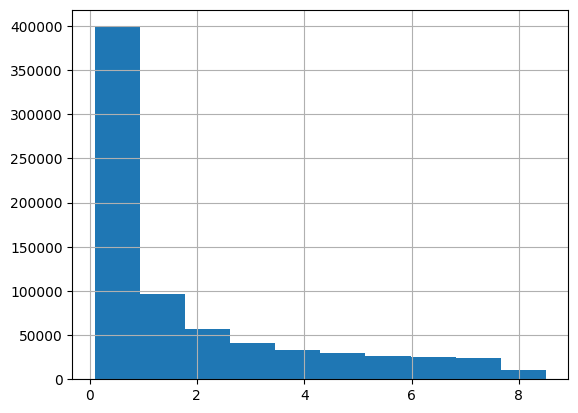

In [14]:
dfs = []
df = train[["series_id", "step", "wakeup_oof"]].copy()
df["event"] = "wakeup"
df["score"] = df["wakeup_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

df = train[["series_id", "step", "onset_oof"]].copy()
df["event"] = "onset"
df["score"] = df["onset_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

train = pd.concat(dfs)
train = train[train["score"]>0.1].reset_index(drop=True)
train["score"].hist()
len(train)

## Dynamic-Range NMS

In [15]:
train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:05<00:00, 48.89it/s]


In [16]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
labels = labels[labels["series_id"].isin(sub["series_id"].unique())]
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

score: 0.7878


event   tolerance
onset   12           0.289130
        36           0.715094
        60           0.800649
        90           0.836235
        120          0.850259
        150          0.859124
        180          0.868798
        240          0.879137
        300          0.886074
        360          0.892039
wakeup  12           0.349896
        36           0.713293
        60           0.791873
        90           0.821181
        120          0.837785
        150          0.848763
        180          0.858004
        240          0.873103
        300          0.887608
        360          0.897255
dtype: float64

In [17]:
%cp -r logs {CFG["output_dir"]}